<div style="text-align:left"><span style="color:black; font-family:Georgia; font-size:1.5em;"><b>Experiement and testing implementations (Parts 1 & 2): Linear PA and Active Learning</center></span></div> <br>

<div style="text-align:center"><span style="color:black; font-family:Georgia; font-size:1.2em;"><b>Mohammed Poul Doust &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; &nbsp;&nbsp; Robin Khatri</b></span></div>

<br>

### 1. Online Passive-Aggressive Algorithms

In [1]:
# Our implementations
from pa import PA # Passive-aggressive
from paActive import AL # Active learning
from utils import test_on_data # Function to test multiple classifiers
from utils import get_accuracy # Simple function to compute accuracy

# Python imports
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
import time
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline

First we test our algorithms on synthetic datasets to see how our algorithm perform on these datasets in comparison to SVM. We shall also visualize the decision boundaries.

### Synthetica data - Make Moons (Classic, first relaxation and second relaxation)  

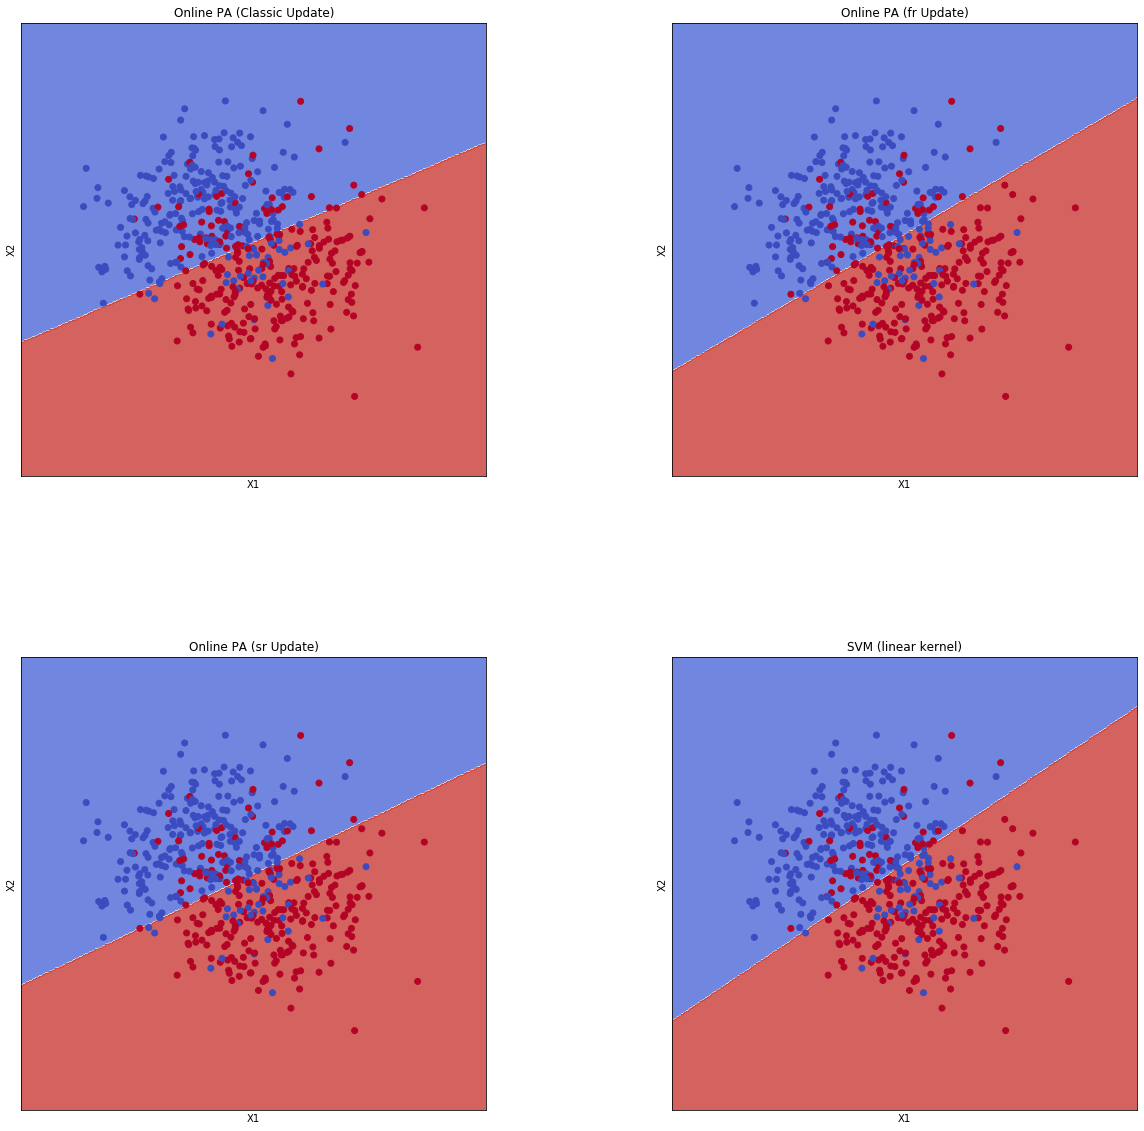

In [2]:
# Visualize for all classifiers
# Data

n_samples = 500
X, y = datasets.make_moons(n_samples = n_samples, noise = 0.5)
y = np.array(2*y - 1, dtype='int')

h = 0.02 # Mesh step size

# Meshgrid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                                   np.arange(y_min, y_max, h))

# Classifiers
classic = PA(C = 0.5, update_='classic')
classic.fit(X,y)
fr = PA(C = 0.5, update_='fr')
fr.fit(X,y)
sr = PA(C = 0.5, update_='sr')
sr.fit(X,y)
svc = SVC(kernel='linear', C=1.0).fit(X, y)

# title for the classifiers
titles = ['Online PA (Classic Update)','Online PA (fr Update)','Online PA (sr Update)','SVM (linear kernel)']
a = 0 # For index in list titles
plt.figure(figsize=(20,20))
for i, clf in enumerate((classic, fr, sr, svc)):
    plt.subplot(2,2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    if clf == svc:
        Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_all(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[a])
    a += 1
plt.show()

To compare accuracies for different C's, we'll create a simple function. 

In [196]:
# A function to test on multiple C values and give accuracy
def accuracy_by_c(X,y,C=None):
    
    if C is None:
        C = [0.001,0.005,0.10,0.25,0.50,0.75,1.00,1.5,2.0,3.0]
    
    Accuracy = np.zeros((len(C),3))
    a = 0

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state = 42)
    train_size = X_train.shape[0]

    for i in range(len(C)):
        c = C[i]
        clf_classic = PA(C=c, update_='classic')
        clf_fr = PA(C=c, update_='fr')
        clf_sr = PA(C=c, update_='sr')
        
        clf_classic.fit(X_train,y_train)
        y_pred = clf_classic.predict_all(X_test)
        Accuracy[a,0] = (y_pred==y_test).mean()*100
            
        clf_fr.fit(X_train,y_train)
        y_pred = clf_fr.predict_all(X_test)
        Accuracy[a,1] = (y_pred==y_test).mean()*100
        
        clf_sr.fit(X_train,y_train)
        y_pred = clf_sr.predict_all(X_test)
        Accuracy[a,2] = (y_pred==y_test).mean()*100
        a += 1
        acc_table = pd.DataFrame(Accuracy, index=C, columns = ['classic','fr','sr'])

    return acc_table

In [203]:
print(accuracy_by_c(X,y))

       classic         fr         sr
0.001     78.0  77.333333  76.666667
0.005     78.0  78.000000  76.666667
0.100     78.0  76.666667  76.666667
0.250     78.0  78.000000  77.333333
0.500     78.0  78.000000  77.333333
0.750     78.0  77.333333  78.000000
1.000     78.0  77.333333  77.333333
1.500     78.0  77.333333  77.333333
2.000     78.0  76.666667  77.333333
3.000     78.0  78.000000  77.333333


In [21]:
# Effect of sample size
n_samples = 10000
X, y = datasets.make_moons(n_samples = n_samples, noise = 0.3)
y = np.array(2*y - 1, dtype='int')

samples = [n_samples, int(n_samples*0.9), int(n_samples*0.8), int(n_samples*0.7)]
Accuracy = np.zeros((len(samples),4))
j = 0

for i in samples:
    X1 = X[0:i,:]
    y1 = y[0:i]
    
    if i == n_samples:
        X2 = X1
        y2 = y1
    else:
        X2 = X[i+1:n_samples,:]
        y2 = y[i+1:n_samples]
        
    classic = PA(C = 0.5, update_='classic')
    classic.fit(X1,y1)
    Accuracy[j,0] = get_accuracy(classic.predict_all(X2),y2) 
    fr = PA(C = 0.5, update_='fr')
    fr.fit(X1,y1)
    Accuracy[j,1] = get_accuracy(fr.predict_all(X2),y2) 
    sr = PA(C = 0.5, update_='sr')
    sr.fit(X1,y1)
    Accuracy[j,2] = get_accuracy(sr.predict_all(X2),y2) 
    svc = SVC(kernel='linear', C=1.0).fit(X1, y1)
    Accuracy[j,3] = get_accuracy(svc.predict(X2),y2)
    print('sample size:%d'%i)
    j += 1
print(Accuracy)

Accuracy is: 76.82
Accuracy is: 80.42
Accuracy is: 80.83
Accuracy is: 85.04
sample size:10000
Accuracy is: 82.38238238238237
Accuracy is: 83.08308308308308
Accuracy is: 83.08308308308308
Accuracy is: 84.78478478478479
sample size:9000
Accuracy is: 74.93746873436719
Accuracy is: 84.54227113556779
Accuracy is: 81.99099549774887
Accuracy is: 84.79239619809906
sample size:8000
Accuracy is: 46.948982994331445
Accuracy is: 84.5615205068356
Accuracy is: 84.46148716238746
Accuracy is: 85.3617872624208
sample size:7000
[[76.82       80.42       80.83       85.04      ]
 [82.38238238 83.08308308 83.08308308 84.78478478]
 [74.93746873 84.54227114 81.9909955  84.7923962 ]
 [46.94898299 84.56152051 84.46148716 85.36178726]]


### Make Blobs(Classic, first relaxation and second relaxation)  

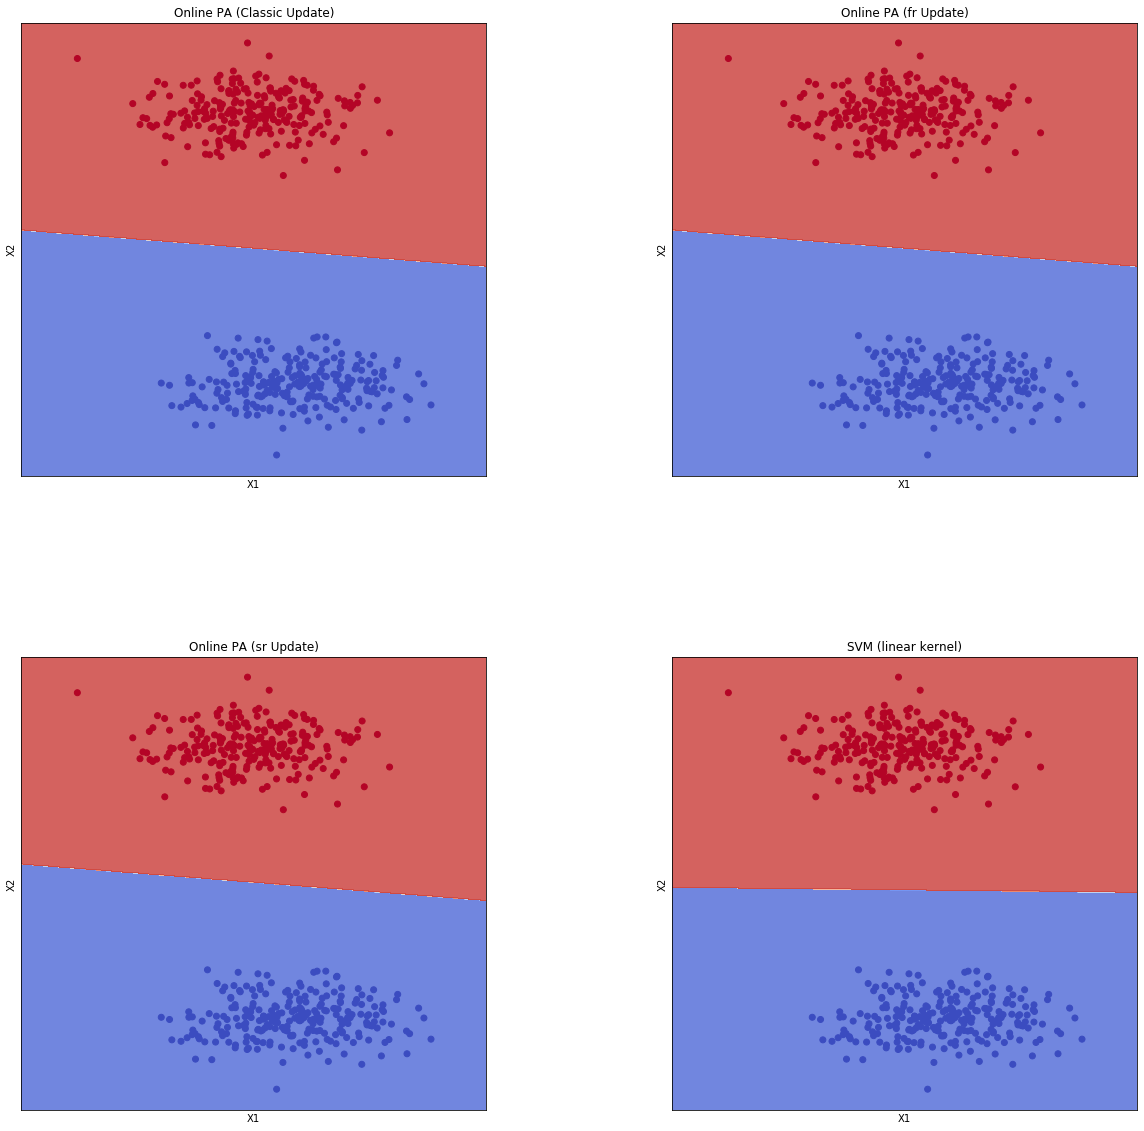

In [201]:
# Make blobs
# Visualize for all classifiers

import matplotlib.pyplot as plt
from sklearn import svm

n_sampels = 500
X, y = datasets.make_blobs(n_samples = n_samples, centers=2)
y = np.array(2*y - 1, dtype='int')

h = 0.02 # Mesh step size

# Meshgrid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                                   np.arange(y_min, y_max, h))

# Classifiers
classic = PA(C = 0.5, update_='classic')
classic.fit(X,y)
fr = PA(C = 0.5, update_='fr')
fr.fit(X,y)
sr = PA(C = 0.5, update_='sr')
sr.fit(X,y)
svc = SVC(kernel='linear', C=1.0).fit(X, y)

# title for the classifiers
titles = ['Online PA (Classic Update)','Online PA (fr Update)','Online PA (sr Update)','SVM (linear kernel)']
a = 0 # For index in list titles
plt.figure(figsize=(20,20))
for i, clf in enumerate((classic, fr, sr, svc)):
    plt.subplot(2,2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    if clf == svc:
        Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_all(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[a])
    a += 1
plt.show()

We shall test on Bank Note Authentication dataset that is a real dataset.

### Banknote Authentication(Classic, first relaxation and second relaxation)  

In [4]:
# Banknote authentication dataset
data = pd.read_csv('data_banknote_authentication.csv', sep =',', header = None)

In [15]:
# For C on real dataset - bank note authentication

# Test accuracy with changing C
temp = list(range(1,21))
C = [round(x*0.05,2) for x in temp]
print('C:',C)
Accuracy_bank = np.zeros((len(C),3))
a = 0

data = np.array(data)
X = data[:,0:3]
y = data[:,4]
n_samples = X.shape[0]
y = np.array(2*y-1, dtype='int')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state = 42)
train_size = X_train.shape[0]

for i in range(len(C)):
    c = C[i]
    clf_classic = PA(C=c, update_='classic')
    clf_fr = PA(C=c, update_='fr')
    clf_sr = PA(C=c, update_='sr')
    
    clf_fr.fit(X_train,y_train)
    y_pred = np.zeros(n_samples-train_size, dtype = 'int')
    for i in range(n_samples-train_size):
        y_pred[i] = clf_fr.predict(X_test[i])
    Accuracy_bank[a,0] = (y_pred==y_test).mean()*100
    
    clf_sr.fit(X_train,y_train)
    y_pred = np.zeros(n_samples-train_size, dtype = 'int')
    for i in range(n_samples-train_size):
        y_pred[i] = clf_sr.predict(X_test[i])
    Accuracy_bank[a,1] = (y_pred==y_test).mean()*100
    a += 1 

C: [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]


In [16]:
print('classic','fr','sr')
print(Accuracy_bank)

fr sr
[[64.7662018  64.23297785]
 [64.23297785 64.31501231]
 [64.31501231 64.31501231]
 [64.47908121 64.31501231]
 [64.43806399 64.47908121]
 [64.43806399 64.47908121]
 [64.43806399 64.47908121]
 [64.43806399 64.47908121]
 [64.43806399 64.47908121]
 [64.43806399 64.47908121]
 [64.43806399 64.47908121]
 [64.43806399 64.47908121]
 [64.43806399 64.47908121]
 [64.43806399 64.47908121]
 [64.43806399 64.47908121]
 [64.43806399 64.47908121]
 [64.43806399 64.47908121]
 [64.43806399 64.47908121]
 [64.43806399 64.47908121]
 [64.43806399 64.47908121]]


In [17]:
# Time Complexity
sample_sizes = [100,500,1000,5000,10000,50000,100000]
time_taken = np.zeros((len(sample_sizes),3)) # 3 classifiers - 1 for each update
a = 0
for i in range(len(sample_sizes)):
    n_samples = sample_sizes[i]
    X, y = datasets.make_moons(n_samples = n_samples, noise = 0.5)
    y = np.array(2*y - 1, dtype='int')
    clf_classic = PA(C=0.5, update_='classic')
    clf_fr = PA(C=0.5,  update_='fr')
    clf_sr = PA(C=0.5, update_='sr')
    
    s = time.time()
    clf_classic.fit(X,y)
    time_taken[a,0] = round(time.time() - s,2)
    
    s = time.time()
    clf_fr.fit(X,y)
    time_taken[a,1] = round(time.time() - s,2)
    
    s = time.time()
    clf_sr.fit(X,y)
    time_taken[a,2] = round(time.time() - s,2)
    a += 1

In [18]:
print('classic','fr','sr')
print(time_taken)

classic fr sr
[[0.   0.   0.  ]
 [0.02 0.02 0.01]
 [0.02 0.02 0.02]
 [0.11 0.12 0.13]
 [0.28 0.24 0.23]
 [1.17 1.27 1.16]
 [2.28 2.35 2.3 ]]


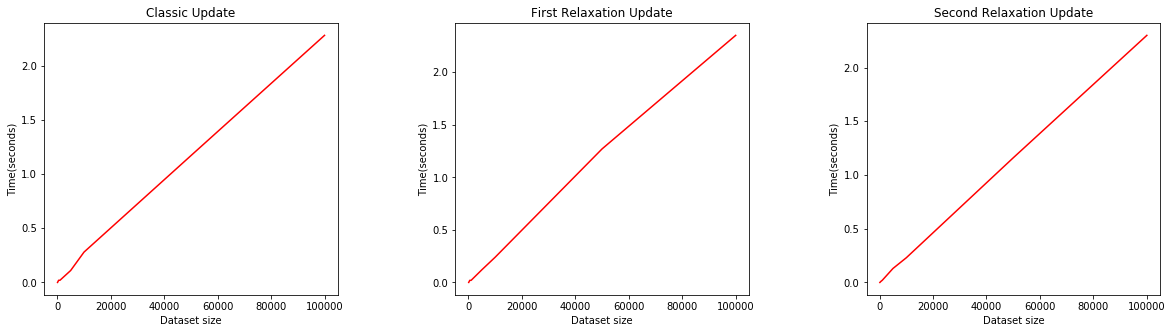

In [19]:
plt.figure(figsize=(20,5))

plt.subplot(1,3, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.title('Classic Update')
plt.xlabel('Dataset size')
plt.ylabel('Time(seconds)')
plt.plot(sample_sizes, time_taken[:, 0], c="red")

plt.subplot(1,3, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.title('First Relaxation Update')
plt.xlabel('Dataset size')
plt.ylabel('Time(seconds)')
plt.plot(sample_sizes, time_taken[:, 1], c="red")


plt.subplot(1,3, 3)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.title('Second Relaxation Update')
plt.xlabel('Dataset size')
plt.ylabel('Time(seconds)')
plt.plot(sample_sizes, time_taken[:, 2], c="red")

### Datasets from LIBSVM webpage

We shall compare online passive-aggressive algorithms with three update strategies and SVM on some datasets available on LIBSVM page and compare time and accuracy performances. We shall test on three datasets: Mushrooms, Ionosphere, Sonar. <br>
<br>

We shall also test on noisy data. To create noisy data, we flip labels of randomly selected rows.

### I. Mushrooms(Classic, first relaxation and second relaxation)  

In [163]:
data = pd.read_csv("mushrooms.csv",header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [164]:
# Encode columns 
# First column is label - encode to -1 +1
data.iloc[:,1:] = data.iloc[:,1:].apply(LabelEncoder().fit_transform)
data.iloc[:,0] = LabelBinarizer(neg_label=-1,pos_label=1).fit_transform(data.iloc[:,0])

In [165]:
data = np.array(data)
X = data[:,1:]
y = np.array(data[:,0],dtype='int')

In [167]:
print(accuracy_by_c(X,y))

         classic         fr         sr
0.001  90.607055  90.730107  89.704676
0.005  90.607055  90.812141  90.853158
0.100  90.607055  90.607055  90.566038
0.250  90.607055  90.607055  90.607055
0.500  90.607055  90.607055  90.607055
0.750  90.607055  90.607055  90.607055
1.000  90.607055  90.607055  90.607055
1.500  90.607055  90.607055  90.607055
2.000  90.607055  90.607055  90.607055
3.000  90.607055  90.607055  90.607055


In [192]:
classifiers = {'SVM': SVC(kernel='linear'), 
                'classic PA': PA(C = 0.1, update_='classic'),
                'fr PA': PA(C = 0.1,update_='fr'),
                'sr PA': PA(C = 0.1, update_='sr')
                }
test_on_data(X,y,classifiers)

'SVM'( time taken:  0.00416111946105957 , accuracy:   79.37 %)
'classic PA'( time taken:  0.008986949920654297 , accuracy:   69.84 %)
'fr PA'( time taken:  0.00818634033203125 , accuracy:   68.25 %)
'sr PA'( time taken:  0.007978677749633789 , accuracy:   73.02 %)


### Introducing Noise

To introduce noise randomly we generate a random integer between 1 and 10. If the generated integer is either 1, 2 or 3 (i.e. probability 3/10), the label is flipped. <br> **Noise probability = 0.3**

In [168]:
def flip_labels(row):
    if random.randint(1, 10) in (1, 2, 3):
        row[0] = -1 * row[0]
    else:
        row[0] = row[0]
    return row
    
data = pd.read_csv("mushrooms.csv")
data.iloc[:,1:] = data.iloc[:,1:].apply(LabelEncoder().fit_transform)
data.iloc[:,0] = LabelBinarizer(neg_label=-1,pos_label=1).fit_transform(data.iloc[:,0])
data = data.apply(flip_labels, axis=1)

In [169]:
data.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,1,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,1,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,-1,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,-1,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1


In [170]:
X = data.iloc[:,1:]
y = data.iloc[:, 0]
X = np.array(X)
y = np.array(y, dtype = 'int')

In [171]:
print(accuracy_by_c(X,y))

        classic         fr         sr
0.001  63.60279  67.131719  66.721379
0.005  63.60279  66.885515  65.038982
0.100  63.60279  63.602790  63.643824
0.250  63.60279  63.602790  63.438654
0.500  63.60279  63.602790  63.520722
0.750  63.60279  63.602790  63.561756
1.000  63.60279  63.602790  63.561756
1.500  63.60279  63.602790  63.602790
2.000  63.60279  63.602790  63.602790
3.000  63.60279  63.602790  63.602790


In [172]:
classifiers = {'SVM': SVC(kernel='linear'), 
                'classic PA': PA(C = 0.1, update_='classic'),
                'fr PA': PA(C = 0.1,update_='fr'),
                'sr PA': PA(C = 0.1, update_='sr')
                }
test_on_data(X,y,classifiers)

'SVM'( time taken:  15.21536922454834 , accuracy:   68.65 %)
'classic PA'( time taken:  0.35733461380004883 , accuracy:   63.6 %)
'fr PA'( time taken:  0.3576793670654297 , accuracy:   63.6 %)
'sr PA'( time taken:  0.38640785217285156 , accuracy:   63.64 %)


**Changing noise levels**

**Noise probability = 0.1**

In [14]:
def flip_labels(row):
    if random.randint(1, 10) == 1:
        row[0] = -1 * row[0]
    else:
        row[0] = row[0]
    return row
    
data = pd.read_csv("mushrooms.csv")
data.iloc[:,1:] = data.iloc[:,1:].apply(LabelEncoder().fit_transform)
data.iloc[:,0] = LabelBinarizer(neg_label=-1,pos_label=1).fit_transform(data.iloc[:,0])
data = data.apply(flip_labels, axis=1)
X = data.iloc[:,1:]
y = data.iloc[:, 0]
X = np.array(X)
y = np.array(y, dtype = 'int')
classifiers = {'SVM': SVC(kernel='linear'), 
                'classic PA': PA(C = 0.1, update_='classic'),
                'fr PA': PA(C = 0.1,update_='fr'),
                'sr PA': PA(C = 0.1, update_='sr')
                }
accuracies_ = test_on_data(X,y,classifiers)

'SVM'( time taken:  17.934386491775513 , accuracy:   86.09 %)
'classic PA'( time taken:  0.29761791229248047 , accuracy:   79.15 %)
'fr PA'( time taken:  0.32033705711364746 , accuracy:   79.15 %)
'sr PA'( time taken:  0.4228241443634033 , accuracy:   79.28 %)


**Noise probability = 0.2**

In [7]:
def flip_labels(row):
    if random.randint(1, 10) in (1, 2):
        row[0] = -1 * row[0]
    else:
        row[0] = row[0]
    return row
    
data = pd.read_csv("mushrooms.csv")
data.iloc[:,1:] = data.iloc[:,1:].apply(LabelEncoder().fit_transform)
data.iloc[:,0] = LabelBinarizer(neg_label=-1,pos_label=1).fit_transform(data.iloc[:,0])
data = data.apply(flip_labels, axis=1)
X = data.iloc[:,1:]
y = data.iloc[:, 0]
X = np.array(X)
y = np.array(y, dtype = 'int')
classifiers = {'SVM': SVC(kernel='linear'), 
                'classic PA': PA(C = 0.1, update_='classic'),
                'fr PA': PA(C = 0.1,update_='fr'),
                'sr PA': PA(C = 0.1, update_='sr')
                }
test_on_data(X,y,classifiers)

'SVM'( time taken:  16.8550865650177 , accuracy:   75.58 %)
'classic PA'( time taken:  0.3125333786010742 , accuracy:   73.2 %)
'fr PA'( time taken:  0.3221259117126465 , accuracy:   73.2 %)
'sr PA'( time taken:  0.354595422744751 , accuracy:   73.12 %)


**Noise probability = 0.4**

In [5]:
def flip_labels(row):
    if random.randint(1, 10) in (1, 2, 3, 4):
        row[0] = -1 * row[0]
    else:
        row[0] = row[0]
    return row
    
data = pd.read_csv("mushrooms.csv")
data.iloc[:,1:] = data.iloc[:,1:].apply(LabelEncoder().fit_transform)
data.iloc[:,0] = LabelBinarizer(neg_label=-1,pos_label=1).fit_transform(data.iloc[:,0])
data = data.apply(flip_labels, axis=1)
X = data.iloc[:,1:]
y = data.iloc[:, 0]
X = np.array(X)
y = np.array(y, dtype = 'int')
classifiers = {'SVM': SVC(kernel='linear'), 
                'classic PA': PA(C = 0.1, update_='classic'),
                'fr PA': PA(C = 0.1,update_='fr'),
                'sr PA': PA(C = 0.1, update_='sr')
                }
test_on_data(X,y,classifiers)

'SVM'( time taken:  11.17545485496521 , accuracy:   59.62 %)
'classic PA'( time taken:  0.3287973403930664 , accuracy:   50.96 %)
'fr PA'( time taken:  0.3426997661590576 , accuracy:   50.96 %)
'sr PA'( time taken:  0.37523508071899414 , accuracy:   50.96 %)


**Noise probability = 0.5**

In [6]:
def flip_labels(row):
    if random.randint(1, 10) in (1, 2, 3, 4, 5):
        row[0] = -1 * row[0]
    else:
        row[0] = row[0]
    return row
    
data = pd.read_csv("mushrooms.csv")
data.iloc[:,1:] = data.iloc[:,1:].apply(LabelEncoder().fit_transform)
data.iloc[:,0] = LabelBinarizer(neg_label=-1,pos_label=1).fit_transform(data.iloc[:,0])
data = data.apply(flip_labels, axis=1)
X = data.iloc[:,1:]
y = data.iloc[:, 0]
X = np.array(X)
y = np.array(y, dtype = 'int')
classifiers = {'SVM': SVC(kernel='linear'), 
                'classic PA': PA(C = 0.1, update_='classic'),
                'fr PA': PA(C = 0.1,update_='fr'),
                'sr PA': PA(C = 0.1, update_='sr')
                }
test_on_data(X,y,classifiers)

'SVM'( time taken:  3.6821699142456055 , accuracy:   48.83 %)
'classic PA'( time taken:  0.3098278045654297 , accuracy:   48.42 %)
'fr PA'( time taken:  0.3588392734527588 , accuracy:   48.42 %)
'sr PA'( time taken:  0.4925720691680908 , accuracy:   48.42 %)


Note: Increasing noise probability over 0.5 does not make sense as then the opposite labels will be treated as true. So, noise probability of 0.2 will gave the same results as with probability 0.8. (Due to binary labels).

**With increasing noise level between 0.1 and 0.5, accuracy over test set decreases.** <br>
**Time taken with online PA algotithms is much lower than that of SVM. SVM is quite slower in presence of noise.**

### II. Ionosphere

In [173]:
iono = pd.read_csv("ionosphere.csv",sep=',',header=None)

In [174]:
iono.shape

(351, 35)

In [175]:
iono.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [176]:
iono.iloc[:,-1] = LabelBinarizer(neg_label=-1,pos_label=1).fit_transform(iono.iloc[:,-1])

In [177]:
iono = np.array(iono)
X,y = iono[:,0:(iono.shape[1]-2)], iono[:,-1]

In [178]:
print(accuracy_by_c(X,y))

        classic         fr         sr
0.001  84.90566  66.981132  70.754717
0.005  84.90566  71.698113  79.245283
0.100  84.90566  83.962264  84.905660
0.250  84.90566  84.905660  84.905660
0.500  84.90566  84.905660  86.792453
0.750  84.90566  85.849057  85.849057
1.000  84.90566  84.905660  85.849057
1.500  84.90566  84.905660  85.849057
2.000  84.90566  84.905660  85.849057
3.000  84.90566  84.905660  85.849057


In [179]:
classifiers = {'SVM': SVC(kernel='linear', C=1.0), 
                'classic PA': PA(C = 1.0, update_='classic'),
                'fr PA': PA(C = 1.0,update_='fr'),
                'sr PA': PA(C = 1.0, update_='sr')
                }
test_on_data(X,y,classifiers)

'SVM'( time taken:  0.007534027099609375 , accuracy:   88.68 %)
'classic PA'( time taken:  0.017314672470092773 , accuracy:   84.91 %)
'fr PA'( time taken:  0.019620180130004883 , accuracy:   84.91 %)
'sr PA'( time taken:  0.01259922981262207 , accuracy:   85.85 %)


### III. Sonar

In [180]:
sonar = pd.read_csv("sonar.csv",sep=',',header=None)

In [181]:
sonar.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [182]:
sonar.shape

(208, 61)

In [183]:
sonar.iloc[:,-1] = LabelBinarizer(neg_label=-1,pos_label=1).fit_transform(sonar.iloc[:,-1])

In [184]:
sonar = np.array(sonar)
X,y = sonar[:,0:(sonar.shape[1]-2)], sonar[:,-1]

In [185]:
print(accuracy_by_c(X,y))

        classic         fr         sr
0.001  69.84127  55.555556  55.555556
0.005  69.84127  55.555556  63.492063
0.100  69.84127  68.253968  73.015873
0.250  69.84127  69.841270  69.841270
0.500  69.84127  69.841270  69.841270
0.750  69.84127  69.841270  69.841270
1.000  69.84127  69.841270  69.841270
1.500  69.84127  69.841270  69.841270
2.000  69.84127  69.841270  69.841270
3.000  69.84127  69.841270  69.841270


In [186]:
test_on_data(X,y,classifiers)

'SVM'( time taken:  0.007863759994506836 , accuracy:   79.37 %)
'classic PA'( time taken:  0.008138895034790039 , accuracy:   69.84 %)
'fr PA'( time taken:  0.008373737335205078 , accuracy:   69.84 %)
'sr PA'( time taken:  0.010215282440185547 , accuracy:   69.84 %)


# 2. Active Learning Algorithms

We shall test active learning algorithm with all three update strategies on ionosphere dataset form LIBSVM webpage.<br><br> We shall also test on multiple $\delta$ values.

### Accuracy with Active learning v. Passive-aggresive and SVM

In [11]:
iono = pd.read_csv("ionosphere.csv",sep=',',header=None)

In [12]:
iono.shape

(351, 35)

In [13]:
iono.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [14]:
iono.iloc[:,-1] = LabelBinarizer(neg_label=-1,pos_label=1).fit_transform(iono.iloc[:,-1])

In [15]:
iono = np.array(iono)
X,y = iono[:,0:(iono.shape[1]-2)], iono[:,-1]

In [23]:
classifiers = {'SVM': SVC(kernel='linear', C=0.5), 
               'PA (First relaxation)': PA(C = 0.5, update_='fr'),
                'Active Learning (First relaxation, delta=3)': AL(C = 0.5, update_='fr',delta=1),
               'Active Learning (First relaxation, delta=7)': AL(C = 0.5, update_='fr',delta=5),
               'Active Learning (First relaxation, delta=10)': AL(C = 0.5, update_='fr',delta=10),
               'Active Learning (First relaxation, delta=20)': AL(C = 0.5, update_='fr',delta=20),
                }
test_on_data(X,y,classifiers)

'SVM'( time taken:  0.003004312515258789 , accuracy:   87.74 %)
'PA (First relaxation)'( time taken:  0.00897073745727539 , accuracy:   84.91 %)
'Active Learning (First relaxation, delta=3)'( time taken:  0.005809307098388672 , accuracy:   78.3 %)
'Active Learning (First relaxation, delta=7)'( time taken:  0.009675979614257812 , accuracy:   79.25 %)
'Active Learning (First relaxation, delta=10)'( time taken:  0.009446859359741211 , accuracy:   83.96 %)
'Active Learning (First relaxation, delta=20)'( time taken:  0.01154947280883789 , accuracy:   81.13 %)


### Effect of $\delta$ on used labels

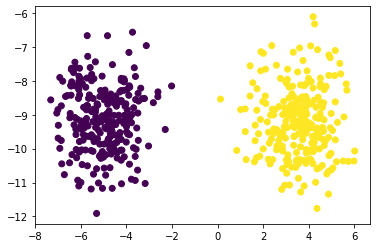

In [53]:
X, y = datasets.make_blobs(n_samples=500, centers=2, n_features=2, random_state = 41)
y = np.array(2*y - 1, dtype='int')
plt.scatter(X[:,0], X[:,1], c=y)

not used labels:  433 out of : 500  Percentage:  86.6 %


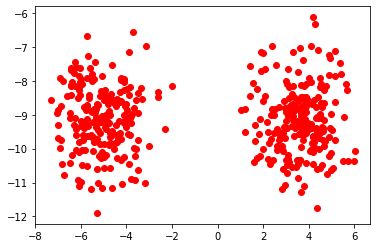

In [54]:
active_learner = AL(0.5, update_='fr', delta = 3)
_, used, not_used = active_learner.fit(X,y)
print("not used labels: ", len(not_used), 'out of :', len(y), ' Percentage: ', (len(not_used) / len(y)) * 100, '%')
used = np.array(used)
not_used = np.array(not_used)
plt.scatter(not_used[:,0], not_used[:,1], c='red')

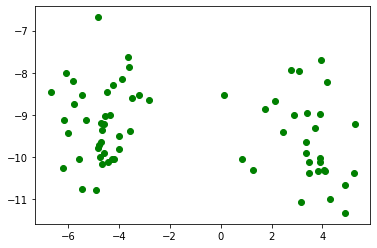

In [55]:
plt.scatter(used[:,0], used[:,1], c='green')

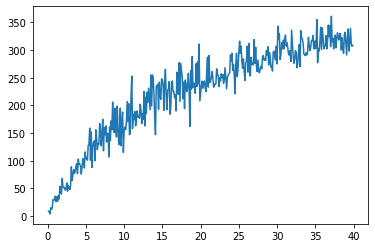

In [57]:
used_points = []
delta_vales = np.arange(0.1, 40, 0.1)
for delts_val in delta_vales :
    active_learner = AL(0.5, update_='fr', delta = delts_val)
    _, used, not_used = active_learner.fit(X,y)
    used_points.append(len(used))
    
plt.plot(delta_vales, used_points)